In [83]:
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import os
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
'''
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
'''

In [17]:
# Load the dataset (update with the correct path)
df_numeric = df = pd.read_csv('clean_data.csv', parse_dates=['Date'], index_col='Date')

# Add store feature (if not already there)
df_numeric['Store'] = df_numeric['Store'].astype(str)

In [18]:
df_numeric.drop(columns=['Unnamed: 0'], inplace=True)

In [19]:
df_numeric

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,0.00,0.00,0.0,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,2,50605.27,False,42.31,2.572,0.00,0.00,0.0,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,3,13740.12,False,42.31,2.572,0.00,0.00,0.0,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,4,39954.04,False,42.31,2.572,0.00,0.00,0.0,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,5,32229.38,False,42.31,2.572,0.00,0.00,0.0,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,45,93,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,...,8.667,B,118221,False,False,False,False,43,10,2012
2012-10-26,45,94,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,...,8.667,B,118221,False,False,False,False,43,10,2012
2012-10-26,45,95,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,...,8.667,B,118221,False,False,False,False,43,10,2012


In [10]:
def preprocess_data(df):
    df['Log_Weekly_Sales'] = np.log1p(df['Weekly_Sales'])
    df_diff = df.copy()
    df_diff['Weekly_Sales'] = df['Weekly_Sales'].diff().dropna()
    df_diff = df_diff.dropna()
    return df, df_diff

In [11]:
def create_features(df):
    df['Lag_1'] = df['Weekly_Sales'].shift(1)
    df['Lag_2'] = df['Weekly_Sales'].shift(2)
    df['Lag_3'] = df['Weekly_Sales'].shift(3)
    df['Rolling_Mean'] = df['Weekly_Sales'].rolling(window=4).mean()
    df['Rolling_Std'] = df['Weekly_Sales'].rolling(window=4).std()
    return df.dropna()  # Drop NaN values created by rolling statistics

In [12]:
def train_test_split(df):
    train_data_diff = df[:int(0.7*(len(df)))]
    test_data_diff = df[int(0.7*(len(df))):]
    return train_data_diff, test_data_diff

In [77]:
def train_models(train_data_diff):
    
    train_data_diff_reset = train_data_diff.reset_index()
    
    # ARIMA Model (AutoARIMA)
    model_auto_arima = auto_arima(train_data_diff['Weekly_Sales'], 
                                  trace=True,
                                  start_p=0, start_q=0, start_P=0, start_Q=0,
                                  max_p=20, max_q=20, max_P=20, max_Q=20, 
                                  seasonal=True, maxiter=200,
                                  information_criterion='aic', 
                                  stepwise=False, suppress_warnings=True, 
                                  D=1, max_D=10, error_action='ignore', 
                                  approximation=False)
    model_auto_arima.fit(train_data_diff['Weekly_Sales'])

    # SARIMAX Model
    sarimax_model = SARIMAX(train_data_diff['Weekly_Sales'],
                        exog=train_data_diff[['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 52))  # Example seasonal values
    sarimax_model_fit = sarimax_model.fit()


    # XGBoost Model
    train_data_diff_reset['IsHoliday'] = train_data_diff_reset['IsHoliday'].astype(int)
    X_train_xgb = train_data_diff_reset[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean', 'Rolling_Std', 'Temperature', 'Fuel_Price', 
                                        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']]
    y_train_xgb = train_data_diff_reset['Weekly_Sales']
    xgb_model = xgb.XGBRegressor(n_estimators=1000, 
                                 learning_rate=0.05, 
                                 max_depth=6, 
                                 subsample=0.7, 
                                 colsample_bytree=0.7)
    xgb_model.fit(X_train_xgb, y_train_xgb)

    return model_auto_arima, sarimax_model_fit, xgb_model

In [98]:
def train_and_save_models(store_id, df_numeric):
    df_store = df_numeric[df_numeric['Store'] == store_id]
    print(len(df_store))
    df_store['IsHoliday'] = df_store['IsHoliday'].astype(int)
    df_store = df_store.drop(columns=['Store'])

    df_store_numeric = df_store.select_dtypes(include=[np.number])
    df_week, df_week_diff = preprocess_data(df_store_numeric.resample('W').mean())
    print(len(df_week_diff))
    # Create lag features and rolling statistics for this store
    df_week_diff = create_features(df_week_diff)

    # Split data into train and test (70% Train, 30% Test)
    train_data_diff = df_week_diff[:int(0.7*(len(df_week_diff)))]
    test_data_diff = df_week_diff[int(0.7*(len(df_week_diff))):]

    # Train the models
    model_auto_arima, sarimax_model_fit, xgb_model = train_models(train_data_diff)

    model_dir = f'models/store_{store_id}'
    os.makedirs(model_dir, exist_ok=True)
    # Save models for this store
    with open(f'{model_dir}_auto_arima.pkl', 'wb') as f:
        pickle.dump(model_auto_arima, f)
    with open(f'{model_dir}_sarimax_model.pkl', 'wb') as f:
        pickle.dump(sarimax_model_fit, f)
    with open(f'{model_dir}_xgb_model.pkl', 'wb') as f:
        pickle.dump(xgb_model, f)

    # Plot predictions for the store before saving the models
    y_pred_arima = model_auto_arima.predict(n_periods=len(test_data_diff))
    exog_test = test_data_diff[['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']]
    y_pred_sarimax = sarimax_model_fit.forecast(steps=len(test_data_diff), exog=exog_test)
    X_test_xgb = test_data_diff[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean', 'Rolling_Std', 'Temperature', 'Fuel_Price', 
                           'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']]
    X_test_xgb['IsHoliday'] = X_test_xgb['IsHoliday'].astype(int)
    y_pred_xgb = xgb_model.predict(X_test_xgb)

    # Ensemble Prediction (Averaging the predictions from all models)
    ensemble_predictions = (y_pred_arima + y_pred_sarimax + y_pred_xgb) / 3

    # Plot predictions
    plot_predictions(train_data_diff, test_data_diff, ensemble_predictions)

    # Compute Evaluation Metrics
    residuals = test_data_diff['Weekly_Sales'] - ensemble_predictions
    
    is_holiday_test = test_data_diff['IsHoliday']  # Assuming you have this column

    mae_arima, rmse_arima, wmae_arima, lb_pvalue_arima, accuracy_arima = evaluate_metrics(test_data_diff['Weekly_Sales'], y_pred_arima, residuals, is_holiday_test)
    mae_sarimax, rmse_sarimax, wmae_sarimax, lb_pvalue_sarimax, accuracy_sarimax = evaluate_metrics(test_data_diff['Weekly_Sales'], y_pred_sarimax, residuals, is_holiday_test)
    mae_xgb, rmse_xgb, wmae_xgb, lb_pvalue_xgb, accuracy_xgb = evaluate_metrics(test_data_diff['Weekly_Sales'], y_pred_xgb, residuals, is_holiday_test)
    mae_ensemble, rmse_ensemble, wmae_ensemble, lb_pvalue_ensemble, accuracy_ensemble = evaluate_metrics(test_data_diff['Weekly_Sales'], ensemble_predictions, residuals, is_holiday_test)

    # Save the evaluation metrics for each model and ensemble in a DataFrame
    metrics = pd.DataFrame({
        'Store_ID': [store_id],
        'mae_AutoARIMA': [mae_arima],
        'rmse_AutoARIMA': [rmse_arima],
        'wmae_AutoARIMA': [wmae_arima],
        'lb_pvalue_AutoARIMA': [lb_pvalue_arima],
        'accuracy_AutoARIMA': [accuracy_arima],
        'mae_SARIMAX': [mae_sarimax],
        'rmse_SARIMAX': [rmse_sarimax],
        'wmae_SARIMAX': [wmae_sarimax],
        'lb_pvalue_SARIMAX': [lb_pvalue_sarimax],
        'accuracy_SARIMAX': [accuracy_sarimax],
        'mae_XGBoost': [mae_xgb],
        'rmse_XGBoost': [rmse_xgb],
        'wmae_XGBoost': [wmae_xgb],
        'lb_pvalue_XGBoost': [lb_pvalue_xgb],
        'accuracy_XGBoost': [accuracy_xgb],
        'mae_Ensemble': [mae_ensemble],
        'rmse_Ensemble': [rmse_ensemble],
        'wmae_Ensemble': [wmae_ensemble],
        'lb_pvalue_Ensemble': [lb_pvalue_ensemble],
        'accuracy_Ensemble': [accuracy_ensemble]
    })
    
    # Save the metrics DataFrame to a CSV file
    metrics.to_csv(f'{model_dir}_metrics.csv', index=False)

In [21]:
print(df_numeric.columns) 

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Super_Bowl',
       'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year'],
      dtype='object')


In [34]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420212 entries, 2010-02-05 to 2012-10-26
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420212 non-null  object 
 1   Weekly_Sales  420212 non-null  float64
 2   IsHoliday     420212 non-null  bool   
 3   Temperature   420212 non-null  float64
 4   Fuel_Price    420212 non-null  float64
 5   MarkDown1     420212 non-null  float64
 6   MarkDown2     420212 non-null  float64
 7   MarkDown3     420212 non-null  float64
 8   MarkDown4     420212 non-null  float64
 9   MarkDown5     420212 non-null  float64
 10  CPI           420212 non-null  float64
 11  Unemployment  420212 non-null  float64
dtypes: bool(1), float64(10), object(1)
memory usage: 38.9+ MB


In [38]:
df_numeric

,Store,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,
2010-02-05,1,24924.50,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
2010-02-05,1,50605.27,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
2010-02-05,1,13740.12,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
2010-02-05,1,39954.04,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
2010-02-05,1,32229.38,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,45,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
2012-10-26,45,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
2012-10-26,45,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667


In [55]:
#df_numeric = df_numeric.drop(columns=['Dept', 'Type', 'Size','Super_Bowl','Labor_Day','Thanksgiving','Christmas','week','month','year'])

In [57]:
print(df_numeric.index.duplicated().sum())

420069


In [20]:
store_ids = df_numeric['Store'].unique()

Training and saving models for Store ID: 1
10226
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1816.359, Time=0.01 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1781.416, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1801.571, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1794.768, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1773.399, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1781.100, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1780.324, Time=0.0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



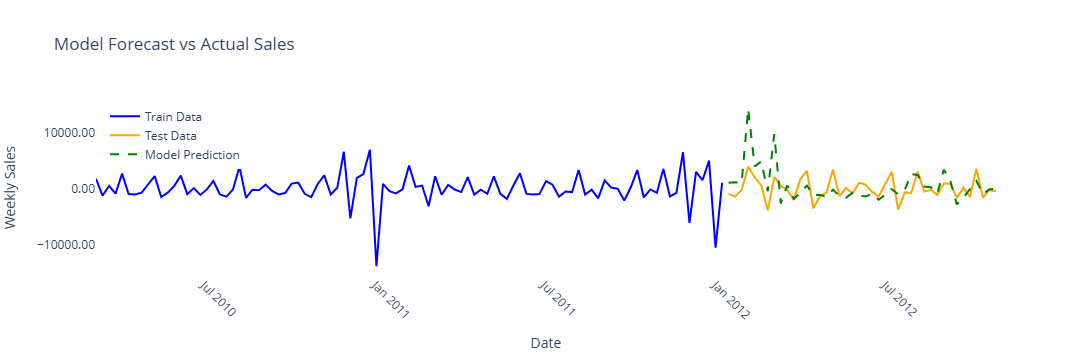

Training and saving models for Store ID: 2
10214
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1897.480, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1871.848, Time=0.02 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1871.935, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1867.599, Time=0.19 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1852.247, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1881.974, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1865.318, Time=0.05 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1862.793, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1880.603, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1859.299, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1869.948, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1869.288, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept  

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



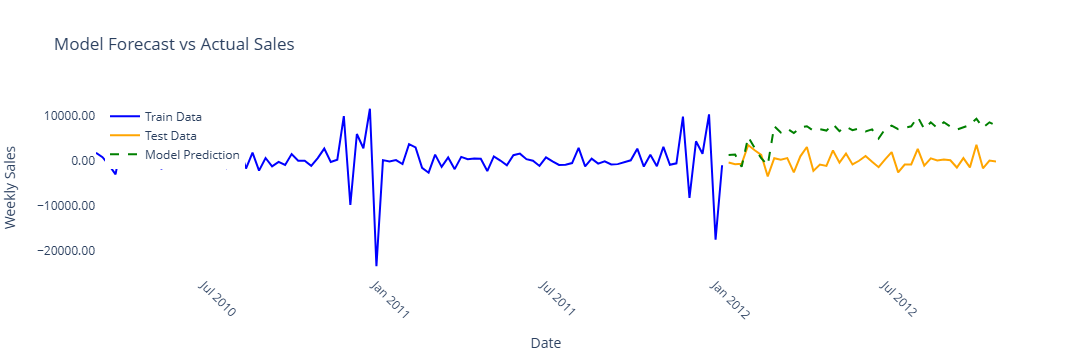

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 3
9026
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1570.171, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1545.154, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1544.962, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1546.861, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1558.920, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1546.841, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1545.084, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1545.403, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1542.550, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1541.17

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



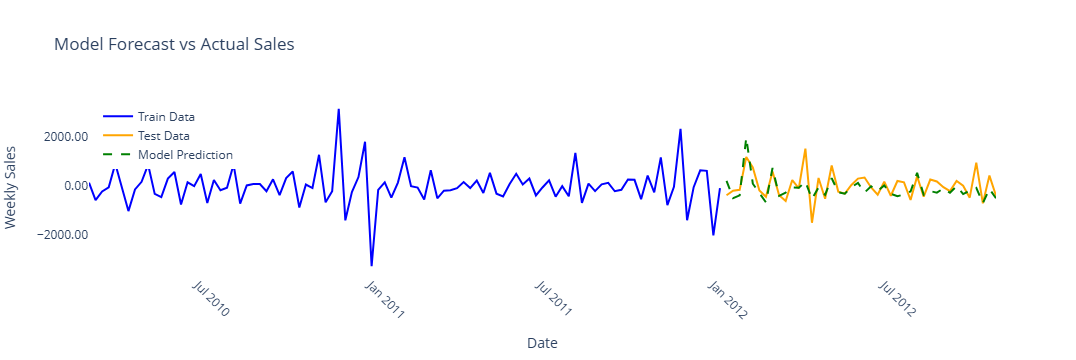

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 4
10267
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1920.428, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1885.010, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1882.876, Time=0.22 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1906.202, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1898.996, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1889.888, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 A

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



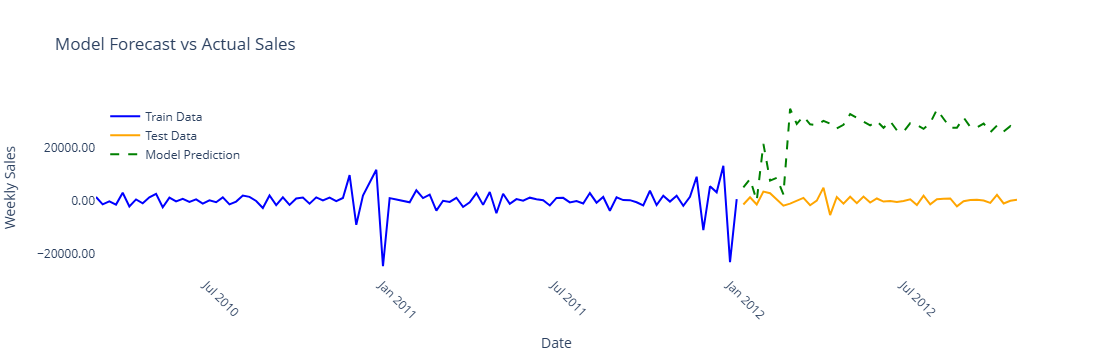

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 5
8978
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1552.403, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1520.738, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1536.550, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1526.787, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1524.276, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1520.904, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1518.960, Time=0.37 se

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



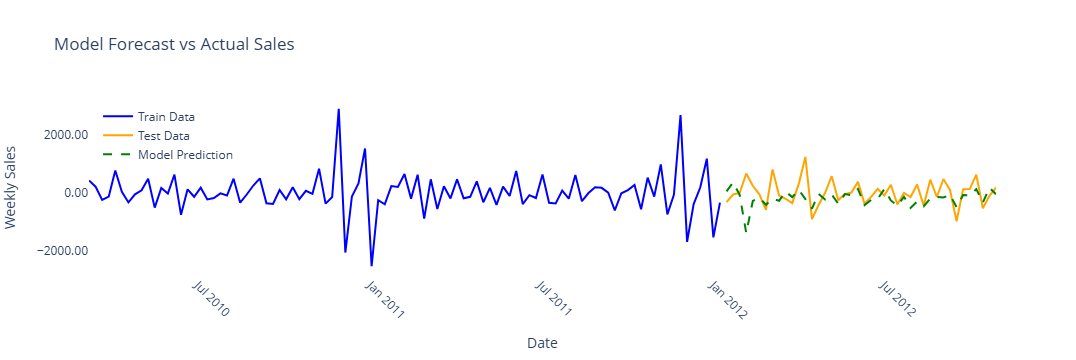

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 6
10189
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1863.384, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1846.204, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1848.265, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1846.410, Time=0.05 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1852.726, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1850.731, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1837.467, Time=0.13 s

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



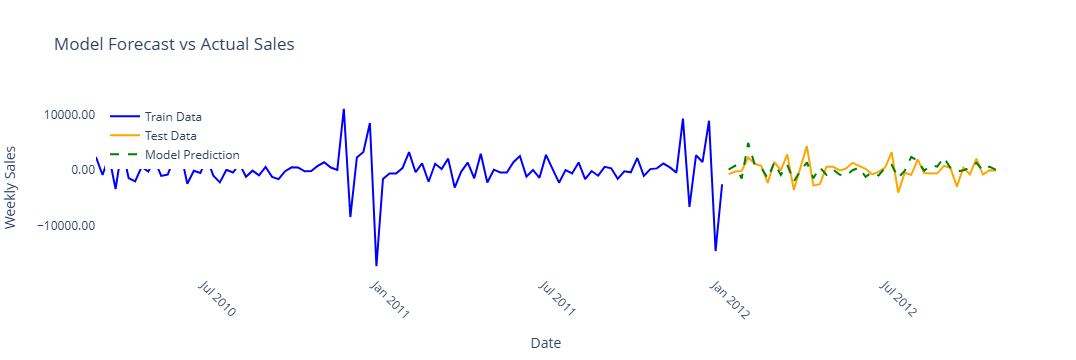

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 7
9738
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1704.048, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1687.190, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1689.678, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1690.758, Time=0.09 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1683.580, Time=0.05 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1679.549, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1690.890, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1689.207, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1690.124, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1688.435, Time=0.11 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1681.774, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1690.903, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1691.196, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[1] inter

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



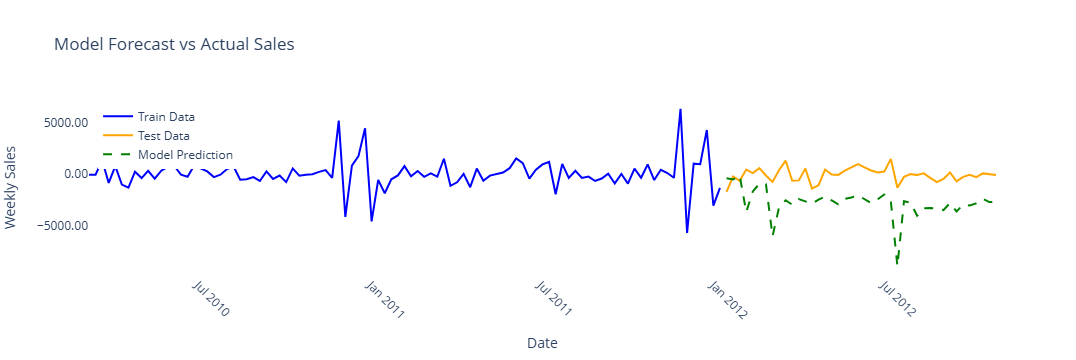

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 8
9883
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1751.793, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1721.191, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1720.792, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1735.728, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1730.815, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1714.262, Time=0.31 sec
 AR

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



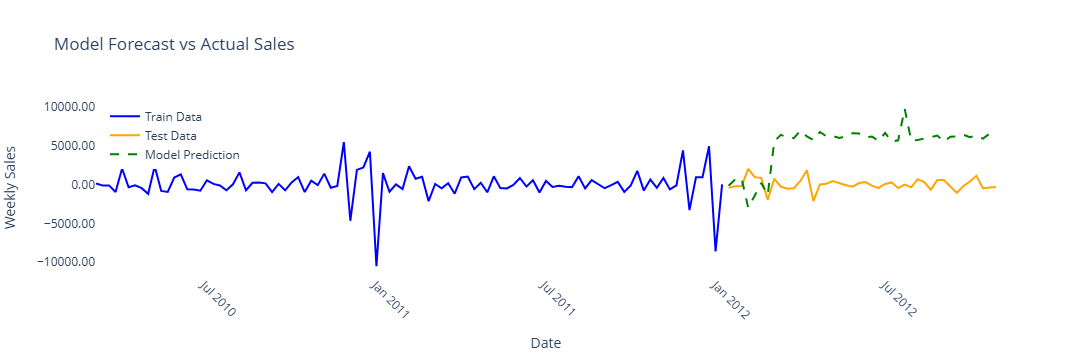

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 9
8834
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1667.685, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1643.220, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1653.087, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1649.403, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,0,0)

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



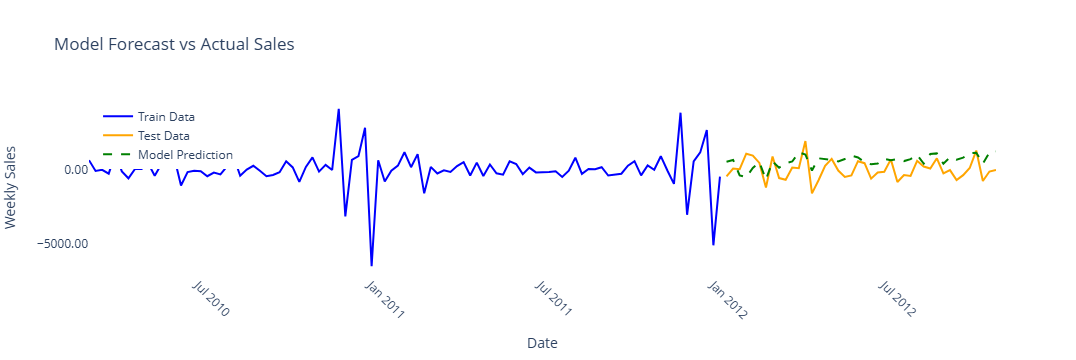

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 10
10260
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1930.195, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1910.792, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1910.627, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1914.468, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1910.445, Time=0.04 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1918.730, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1915.355, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1904.535, Time=0.06 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1903.830, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1916.223, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



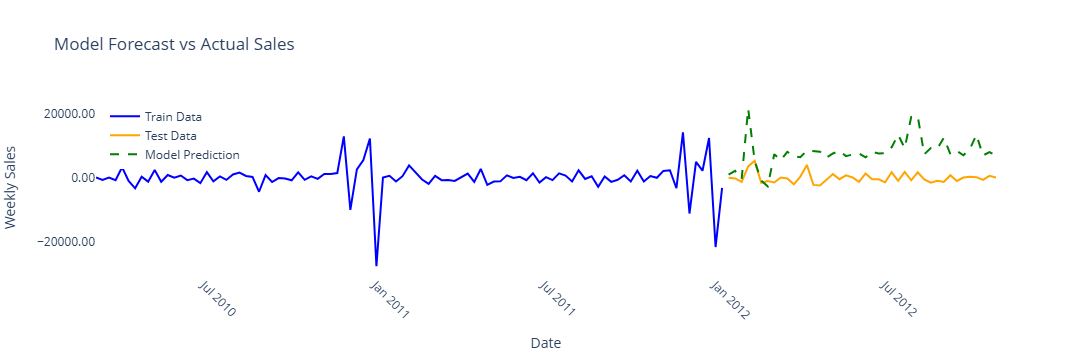

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 11
10033
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1829.608, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1809.590, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1801.044, Time=0.16 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1819.658, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1795.057, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1816.977, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



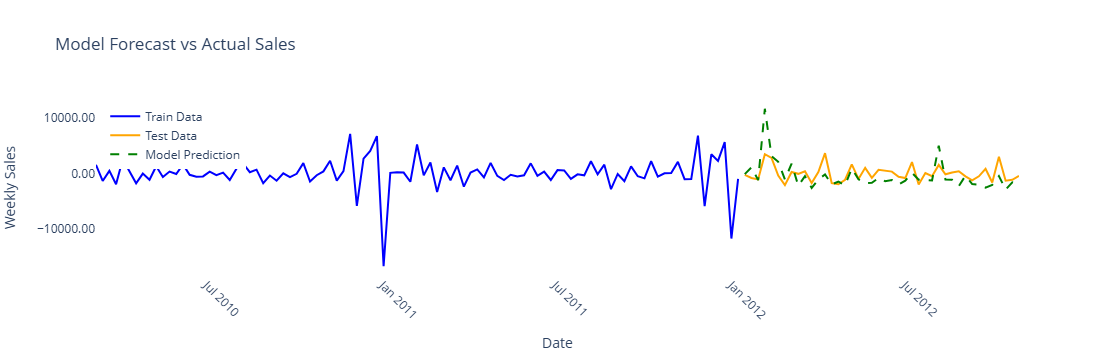

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 12
9665
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1808.688, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1777.258, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1791.053, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1787.131, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,0,0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



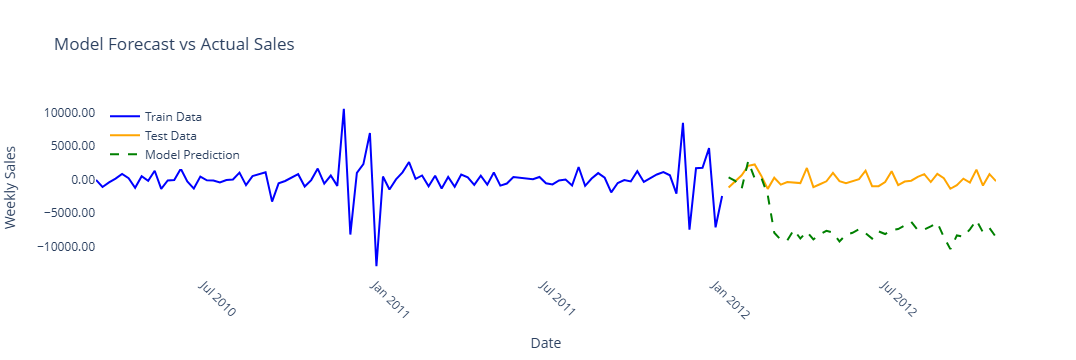

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 13
10457
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1913.253, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1889.999, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1900.853, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1877.208, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1899.043, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1878.998, Time=0.12 sec
 

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 14
10005
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1943.578, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1908.518, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1910.828, Time=0.11 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1920.346, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1912.676, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1906.070, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1918.567, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1904.877, Time=

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 15
9854
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1765.645, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1745.007, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1754.563, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1749.754, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(3,0,0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 16
9403
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1671.810, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1658.766, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1660.192, Time=0.09 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1658.634, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1662.374, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1661.781, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1654.790, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1656.254, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1663.135, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1655.813, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1655.550, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1655.379, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=1656.236, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[1] intercept  

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 17
9812
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1766.961, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1713.773, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1715.773, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1729.611, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1715.772, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1715.864, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1723.659, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 s

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 18
9805
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1844.332, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1818.509, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1821.238, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1821.827, Time=0.04 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1827.100, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1822.764, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1819.028, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1825.668, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1819.429, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1818.314, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=1817.059, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=1817.757, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=181

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 19
10114
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1857.248, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1833.285, Time=0.06 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1845.252, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1843.645, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1828.390, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1834.260, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1834.621, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 20
10173
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1920.347, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1894.160, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1896.059, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1898.993, Time=0.06 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1904.097, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1897.714, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1892.104, Time=0.05 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1902.203, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1887.451, 

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 21
9544
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1787.766, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1767.507, Time=0.03 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1779.122, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1773.031, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1767.033, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1760.782, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1757.880, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=1755.869, Time=0.0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 22
9646
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1828.508, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1808.052, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1816.191, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1813.405, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,0,0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 23
10018
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1888.413, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1879.048, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1881.730, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1882.602, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1882.376, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 24
10210
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1838.020, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1808.950, Time=0.05 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1807.240, Time=0.22 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1825.123, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1803.428, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1820.504, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1806.227, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1806.456, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=1808.093, Tim

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 25
9768
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1739.511, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1724.937, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1725.574, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1730.318, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1728.149, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 26
9844
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1754.118, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1722.837, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1734.391, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1726.158, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1733.991, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 27
10196
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1903.278, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1874.287, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1883.373, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1877.557, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1881.928, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1867.192, Time=0.12 sec
 

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 28
10099
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1867.186, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1842.615, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1808.492, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1834.111, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(3,0,

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 29
9424
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1747.061, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1722.896, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1735.840, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1728.010, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1724.116, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 30
7139
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1517.584, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1473.987, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1475.121, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1477.064, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1476.286, Time=0.16 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1471.346, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1486.936, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1475.135, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1476.877, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1479.055, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1478.125, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1476.879, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1478.692, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[1] inte

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 31
10101
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1796.559, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1751.223, Time=0.05 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1755.467, Time=0.30 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1775.221, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1766.771, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1744.493, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1743.193, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=1743.502, Time=0.0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 32
10170
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1799.484, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1769.539, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1783.379, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1779.459, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,0,

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 33
6478
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1500.098, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1466.642, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1467.007, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1458.057, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1437.300, Time=0.16 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1435.539, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1495.471, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1468.001, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1457.147, Time=0.19 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1434.551, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1483.392, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1455.441, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1442.250, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[1] inte

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 34
10206
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1752.502, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1713.025, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1713.096, Time=0.26 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1732.686, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1714.302, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1705.162, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1726.706, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.92 

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 35
9402
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1870.748, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1838.901, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1840.051, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1841.329, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1841.728, Time=0.12 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1818.310, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1853.951, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1839.452, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1833.053, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1834.284, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1847.726, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1841.861, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 36
6197
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1541.811, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1511.213, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1509.094, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1510.370, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1507.535, Time=0.17 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1507.852, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1535.745, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1510.521, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1508.945, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1524.497, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1507.033, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1507.721, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 37
7198
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1563.160, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1497.202, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1494.306, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1495.020, Time=0.10 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1496.978, Time=0.15 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1498.710, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1508.900, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1493.178, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1494.279, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1496.235, Time=0.17 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1503.070, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1494.707, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1496.239, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[1] inte

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 38
7351
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1561.268, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1498.423, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1499.354, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1500.431, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1499.269, Time=0.20 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1535.409, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1499.609, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1491.331, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1529.612, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1500.758, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=i

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 39
9839
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1871.113, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1841.976, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1842.209, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1842.495, Time=0.09 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1813.704, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1855.341, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1850.512, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1846.805, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 40
10003
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1774.153, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1738.967, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1752.140, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1742.834, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1751.079, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 41
10057
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1853.600, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1816.944, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1830.324, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1806.186, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1827.448, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1805.117, Time=0.12 sec
 

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 42
6907
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1687.330, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.04 sec


C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1620.803, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1606.249, Time=0.16 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1686.419, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1622.630, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1604.019, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1653.420, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1575.831, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1559.276, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1552.780, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AI

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 43
6727
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1633.652, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1594.394, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1597.073, Time=0.29 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1622.335, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1607.538, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1593.702, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1583.220, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1579.183, Time=0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 44
7142
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1494.716, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1455.531, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1439.054, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,0,0)(0,0

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training and saving models for Store ID: 45
9610
142
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1787.375, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1765.321, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1764.224, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1775.846, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1772.510, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\yeshwant\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\2945415381.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
for store_id in store_ids:
    print(f"Training and saving models for Store ID: {store_id}")
    train_and_save_models(store_id, df_numeric)

In [88]:
def calculate_accuracy(true, pred, tolerance=0.05):
    percentage_error = np.abs(true - pred) / true
    accuracy = np.mean(percentage_error <= tolerance) * 100
    return accuracy

In [89]:
def wmae(true, pred, is_holiday):
    weights = is_holiday.apply(lambda x: 5 if x else 1)
    return np.sum(weights * np.abs(true - pred)) / np.sum(weights)

In [90]:
def ljung_box_test(residuals, lags=10):
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].values[0]
    return lb_pvalue

In [91]:
def evaluate_metrics(true, pred, residuals, is_holiday):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    wmae_score = wmae(true, pred, is_holiday)
    lb_pvalue = ljung_box_test(residuals)
    accuracy = calculate_accuracy(true, pred)
    return mae, rmse, wmae_score, lb_pvalue, accuracy

In [92]:
def plot_predictions(train_data, test_data, y_pred, title='Model Forecast vs Actual Sales'):
    fig = go.Figure()

    # Plot Train Data
    fig.add_trace(go.Scatter(x=train_data.index, y=train_data['Weekly_Sales'], mode='lines', name='Train Data', line=dict(color='blue', width=2)))
    
    # Plot Test Data
    fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Weekly_Sales'], mode='lines', name='Test Data', line=dict(color='orange', width=2)))
    
    # Plot Predictions
    fig.add_trace(go.Scatter(x=test_data.index, y=y_pred, mode='lines', name='Model Prediction', line=dict(color='green', width=2, dash='dash')))
    
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Weekly Sales',
        template='plotly',
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(x=0.01, y=0.99, font=dict(size=12)),
        xaxis=dict(tickangle=45),
        yaxis=dict(tickformat=".2f"),
    )
    
    fig.show()

In [125]:
def predict_sales(store_id, forecast_period):
    # Load the trained models
    with open(f'models/store_{store_id}/store_{store_id}_auto_arima.pkl', 'rb') as f:
        model_auto_arima = pickle.load(f)
    with open(f'models/store_{store_id}/store_{store_id}_sarimax_model.pkl', 'rb') as f:
        sarimax_model_fit = pickle.load(f)
    with open(f'models/store_{store_id}/store_{store_id}_xgb_model.pkl', 'rb') as f:
        xgb_model = pickle.load(f)


    df_store = df_numeric[df_numeric['Store'] == store_id]
    df_store['IsHoliday'] = df_store['IsHoliday'].astype(int)
    df_store = df_store.drop(columns=['Store'])

    df_store_numeric = df_store.select_dtypes(include=[np.number])
    df_week, df_week_diff = preprocess_data(df_store_numeric.resample('W').mean())

    df_week_diff = create_features(df_week_diff)

    # Make predictions using the models (for forecast_period)
    y_pred_arima = model_auto_arima.predict(n_periods=forecast_period)

    features = ['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean', 'Rolling_Std', 'CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']
    exog_future = df_week_diff[features].iloc[-forecast_period:]
    y_pred_sarimax = sarimax_model_fit.forecast(steps=forecast_period, exog=exog_future)
    
    xgb_features = ['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean', 'Rolling_Std', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
    xgb_input = df_week_diff[xgb_features].iloc[-forecast_period:]
    y_pred_xgb = xgb_model.predict(xgb_input)

    # Ensemble Prediction (Averaging the predictions from all models)
    ensemble_predictions = (y_pred_arima + y_pred_xgb ) / 2

    # Plot predictions using Plotly
    fig = go.Figure()

    # Plot ARIMA Prediction
    fig.add_trace(go.Scatter(x=df_week_diff.index[-forecast_period:], y=y_pred_arima, mode='lines', name='ARIMA Forecast', line=dict(color='blue')))
    # Plot SARIMAX Prediction
    #fig.add_trace(go.Scatter(x=df_week_diff.index[-forecast_period:], y=y_pred_sarimax, mode='lines', name='SARIMAX Forecast', line=dict(color='red')))
    # Plot XGBoost Prediction
    fig.add_trace(go.Scatter(x=df_week_diff.index[-forecast_period:], y=y_pred_xgb, mode='lines', name='XGBoost Forecast', line=dict(color='green')))
    # Plot Ensemble Prediction
    fig.add_trace(go.Scatter(x=df_week_diff.index[-forecast_period:], y=ensemble_predictions, mode='lines', name='Ensemble Forecast', line=dict(color='orange', dash='dot')))

    fig.update_layout(
        title=f'Store {store_id} Sales Forecast for {forecast_period} Days',
        xaxis_title='Date',
        yaxis_title='Weekly Sales',
        template='plotly',
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(x=0.01, y=0.99, font=dict(size=12)),
        xaxis=dict(tickangle=45),
        yaxis=dict(tickformat=".2f"),
    )

    fig.show()
    print(f"\n🔹 Forecast Results for Store {store_id} ({forecast_period} Days):\n")
    print("▶ ARIMA Forecast:\n", y_pred_arima)
    #print("▶ SARIMAX Forecast:\n", y_pred_sarimax)
    print("▶ XGBoost Forecast:\n", y_pred_xgb)
    print("▶ Ensemble Forecast:\n", ensemble_predictions)

In [102]:
store_id = '1'  # Example store ID as string
forecast_period = 2  # Example forecast period in days (1 week or 2 weeks)

C:\Users\yeshwant\AppData\Local\Temp\ipykernel_25920\1735306967.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



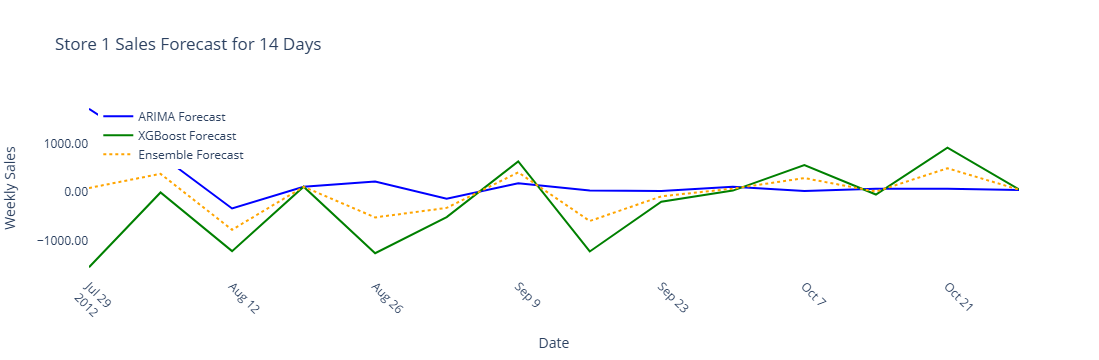


🔹 Forecast Results for Store 1 (14 Days):

▶ ARIMA Forecast:
 2012-01-15    1718.680085
2012-01-22     761.881350
2012-01-29    -334.542436
2012-02-05     110.844046
2012-02-12     219.473797
2012-02-19    -132.898179
2012-02-26     184.481554
2012-03-04      33.905739
2012-03-11      25.509100
2012-03-18     114.481195
2012-03-25      24.228751
2012-04-01      73.017057
2012-04-08      69.049993
2012-04-15      47.341377
Freq: W-SUN, dtype: float64
▶ XGBoost Forecast:
 [-1544.6599       -4.4435606 -1213.2866      113.607346  -1257.2981
  -512.8965      633.75714   -1221.0457     -194.97281      34.155758
   558.6234      -46.812675    917.42706      58.470806 ]
▶ Ensemble Forecast:
 2012-01-15     87.010087
2012-01-22    378.718895
2012-01-29   -773.914528
2012-02-05    112.225696
2012-02-12   -518.912149
2012-02-19   -322.897332
2012-02-26    409.119348
2012-03-04   -593.569958
2012-03-11    -84.731854
2012-03-18     74.318476
2012-03-25    291.426082
2012-04-01     13.102191
2012-0

In [126]:
predict_sales(store_id, forecast_period)